# Obermeyer et-xAI

In this Jupyternotebook I (Pablo Suárez Reyero) introduce all the necessary code to develop the individual project (worth $60\%$) of the course: $$\text{Explainable and Ethical Artificial Intelligence for Engineering - 18-fi-2130-vl}$$ from $\text{Technische Universität Darmstadt}$

## Library imports
Below, you may find all the libraries I used to implement and develop this coding project. ADD A REQUIREMENTS.TXT

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # training and test libraries
from xgboost import XGBRegressor, XGBClassifier # model training libraries
from sklearn.metrics import mean_squared_error, r2_score # regression model
from sklearn.metrics import roc_auc_score, classification_report # classification model
import shap

/Users/pablosreyero/opt/anaconda3/envs/ExplainableAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading the raw data

In [2]:
df = pd.read_csv("data_new.csv")
print(df.head())

   risk_score_t  program_enrolled_t  cost_t  cost_avoidable_t  bps_mean_t  \
0      1.987430                   0  1200.0               0.0         NaN   
1      7.677934                   0  2600.0               0.0       119.0   
2      0.407678                   0   500.0               0.0         NaN   
3      0.798369                   0  1300.0               0.0       117.0   
4     17.513165                   0  1100.0               0.0       116.0   

   ghba1c_mean_t  hct_mean_t  cre_mean_t  ldl_mean_t   race  ...  \
0            5.4         NaN    1.110000       194.0  white  ...   
1            5.5        40.4    0.860000        93.0  white  ...   
2            NaN         NaN         NaN         NaN  white  ...   
3            NaN         NaN         NaN         NaN  white  ...   
4            NaN        34.1    1.303333        53.0  white  ...   

   trig_min-high_tm1  trig_min-normal_tm1  trig_mean-low_tm1  \
0                  0                    0                  0   


## Data inspection


In the following cell we inspect the basics of the data, aiming to know:
- Number of rows and columns (attributes)
- Any missing values? If so $\rightarrow$ fill them or delete the whole row (as we don't have that much data: $\sim 49000$ we will not delete the whole row, but rather replace all `NaN` values with the mean or the median value)
- Are there any outliers? If so $\rightarrow$ we'll get rid of them, as they may penalize training and model validation.
- Variable types.
- Maximum and minimum values.
- Basic statistics


In [3]:
# Data basics
print(df.shape)
print(df.info())
print(df.describe())

num_rows = len(df)
print(f"Number of rows: {num_rows}")
print(f"\nVariable types:\n{ df.dtypes}")
print(f"\nColumn names:\n{df.columns.tolist()}")

# let's get some data statistics
numeric_cols = df.select_dtypes(include="number")
print("\nStatistics for numeric columns:")
print(f"Mean:\n{numeric_cols.mean()}")
print(f"\nStandard deviation:\n{numeric_cols.std()}")
print(f"\nMedian:\n{numeric_cols.median()}")

# 5. Extreme values (min and max)
print(f"\nMinimum values:\n{numeric_cols.min()}")
print(f"\nMaximum values:\n{numeric_cols.max()}")

# let's see which columns have NaN values
cols_with_nan = df.columns[df.isna().any()].tolist()
print(f"Columnas with NaN values:\n{cols_with_nan}")

(48784, 160)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48784 entries, 0 to 48783
Columns: 160 entries, risk_score_t to gagne_sum_t
dtypes: float64(22), int64(137), object(1)
memory usage: 59.6+ MB
None
       risk_score_t  program_enrolled_t         cost_t  cost_avoidable_t  \
count  48784.000000        48784.000000   48784.000000      48784.000000   
mean       4.393692            0.009265    7659.716300       2434.722450   
std        5.519582            0.095811   17989.921192      12058.341779   
min        0.000000            0.000000       0.000000          0.000000   
25%        1.443859            0.000000    1200.000000          0.000000   
50%        2.887719            0.000000    2800.000000          0.000000   
75%        5.350773            0.000000    6600.000000        100.000000   
max      100.000000            1.000000  550500.000000     642700.000000   

         bps_mean_t  ghba1c_mean_t    hct_mean_t    cre_mean_t    ldl_mean_t  \
count  38116.000000   132

## Controlling Temporal Data Leakage in the Model

In this notebook, I focus on predicting an outcome at time *t* using only the information that would have been available at *t‑1*. Any variable measured at *t* cannot be used as a predictor, because doing so introduces future information into the model. This type of leakage inflates performance and prevents the model from being usable in a real setting.

In practice, at time *t‑1* I do not have access to `cost_t`, `gagne_sum_t`, `risk_score_t`, or any other outcome recorded at *t*. The model must therefore be trained under the same constraints it will face when deployed.

To maintain this consistency, I review each variable and keep only those that would genuinely be known at prediction time.

---

## Variables Removed

I remove the following from the predictor set:

- `risk_score_t`, since it is already the output of another model.
- `cost_t`, which is the target I aim to predict.
- All variables ending in `_t`, because they represent outcomes at time *t*.
- Any constructed target or any feature derived from future information.

---

## Variables Retained

I keep only information available at *t‑1*, such as:

- Allowed demographic attributes.
- Biomarkers with the suffix `_tm1`.
- Comorbidities with the suffix `_tm1`.
- Costs with the suffix `_tm1`.
- Utilization variables with the suffix `_tm1`.

These reflect the patient’s state before the prediction moment and do not introduce future information.

---

## Summary

The model must be trained under the same temporal constraints it will face in real use. For that reason, I restrict the predictors to variables available at *t‑1* and remove anything that encodes information from *t*. This prevents data leakage and ensures that the estimated performance is realistic and reproducible.


In [4]:
# All time t variables (future outcomes)
t_columns = [col for col in df.columns if col.endswith('_t')]

# All time t-1 predictors
tm1_columns = [col for col in df.columns if col.endswith('_tm1')]

print("Time t columns:", t_columns)
print("Time t-1 columns:", tm1_columns)

# Store race separately for fairness analysis (if available)
if 'race' in df.columns:
    race = df['race']
else:
    race = None

Time t columns: ['risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'bps_mean_t', 'ghba1c_mean_t', 'hct_mean_t', 'cre_mean_t', 'ldl_mean_t', 'gagne_sum_t']
Time t-1 columns: ['dem_age_band_18-24_tm1', 'dem_age_band_25-34_tm1', 'dem_age_band_35-44_tm1', 'dem_age_band_45-54_tm1', 'dem_age_band_55-64_tm1', 'dem_age_band_65-74_tm1', 'dem_age_band_75+_tm1', 'alcohol_elixhauser_tm1', 'anemia_elixhauser_tm1', 'arrhythmia_elixhauser_tm1', 'arthritis_elixhauser_tm1', 'bloodlossanemia_elixhauser_tm1', 'coagulopathy_elixhauser_tm1', 'compdiabetes_elixhauser_tm1', 'depression_elixhauser_tm1', 'drugabuse_elixhauser_tm1', 'electrolytes_elixhauser_tm1', 'hypertension_elixhauser_tm1', 'hypothyroid_elixhauser_tm1', 'liver_elixhauser_tm1', 'neurodegen_elixhauser_tm1', 'obesity_elixhauser_tm1', 'paralysis_elixhauser_tm1', 'psychosis_elixhauser_tm1', 'pulmcirc_elixhauser_tm1', 'pvd_elixhauser_tm1', 'renal_elixhauser_tm1', 'uncompdiabetes_elixhauser_tm1', 'valvulardz_elixhauser_tm1', 'wtlo

Now, let us define our targets for both the regression and classification tasks

In [5]:
# Regression target
y_reg = df['cost_t']

# Classification target (High health burden using Gagne index)
threshold = df['gagne_sum_t'].quantile(0.75)
df['high_need'] = (df['gagne_sum_t'] >= threshold).astype(int)
y_clf = df['high_need']

print("High-need threshold:", threshold)
print("Class balance:\n", y_clf.value_counts(normalize=True))

High-need threshold: 2.0
Class balance:
 high_need
0    0.683831
1    0.316169
Name: proportion, dtype: float64


We are ready to define now our feature matrix. Note that this si the most efficient way, as I don't have to manually drop `risk_score_t` or `cost_t`. Both variables end with the suffix `_t`, and our feature selection process keeps only columns ending in `_tm1`. By restricting the predictors to `_tm1` variables, any column representing information from time *t* is automatically excluded.

This approach is safer and more reliable than removing individual variables by hand, since it prevents accidental inclusion of future information and keeps the preprocessing consistent across datasets.


In [6]:
X = df[tm1_columns].copy()

## Train/Test Split

In this step, we split the dataset into training and testing sets. We use the training set to fit our models and the testing set to evaluate their performance on unseen data. This allows us to simulate a realistic deployment scenario and assess whether the model generalises beyond the data it was trained on.

We follow standard machine learning practice by reserving a portion (e.g., 20%) of the data for testing. This prevents overfitting and ensures that performance metrics reflect true predictive ability rather than memorisation.

This step is aligned with the modelling principles discussed in **Session 6: Interpretable Machine Learning**, where we studied Decision Trees and Regression models and emphasised the importance of proper validation when evaluating predictive systems.

In [7]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

## Model Training

In this step, we train two predictive models:

1. A regression model to predict future healthcare cost.
2. A classification model to predict high health burden.

We use tree-based models (e.g., Gradient Boosting or XGBoost) because they handle nonlinear relationships well and perform strongly on tabular healthcare data.

Although individual Decision Trees are inherently interpretable (as discussed in **Session 6: Interpretable Machine Learning**), ensemble methods such as Gradient Boosting are more complex and behave as black-box models. For this reason, we later apply explainability techniques to understand how these models make decisions.

Our objective here is not only predictive accuracy but also to enable later interpretability analysis.

In [8]:
# regression model
reg_model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

reg_model.fit(X_train_reg, y_train_reg)

# classification model
clf_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    eval_metric='logloss'
)

clf_model.fit(X_train_clf, y_train_clf)

,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Model Evaluation

After training the models, we evaluate their predictive performance using appropriate metrics.

For the regression task, we use metrics such as RMSE and R² to measure how accurately the model predicts future costs.

For the classification task, we use AUC, precision, recall, and F1-score to evaluate how well the model identifies patients with high health burden.

This evaluation allows us to compare predictive performance across tasks. However, strong performance alone does not guarantee fairness or ethical alignment. Therefore, performance metrics are only the first step in our analysis.

This reflects the critical perspective introduced in **Session 6**, where we learned that evaluation must go beyond raw accuracy.

In [9]:
# Regression evaluation
y_pred_reg = reg_model.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n--- Regression Results ---")
print("RMSE:", rmse)
print("R2:", r2)

# Classification evaluation
y_pred_proba = clf_model.predict_proba(X_test_clf)[:, 1]
auc = roc_auc_score(y_test_clf, y_pred_proba)

print("\n--- Classification Results ---")
print("AUC:", auc)
print(classification_report(y_test_clf, clf_model.predict(X_test_clf)))


--- Regression Results ---
RMSE: 15466.771742522258
R2: 0.26020410644994085

--- Classification Results ---
AUC: 0.9376000228372668
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6697
           1       0.84      0.86      0.85      3060

    accuracy                           0.90      9757
   macro avg       0.89      0.89      0.89      9757
weighted avg       0.91      0.90      0.90      9757



## Fairness Analysis

In this step, we analyse whether the model’s predictions differ systematically across demographic groups (e.g., race).

We compare average predicted risk across groups and examine whether disparities exist between predicted outcomes and actual health burden.

This step is crucial because predictive models may optimise their objective function while still reproducing structural inequalities. By separating model performance from fairness evaluation, we ensure a more responsible assessment of the system.

This analysis prepares the ground for explainability techniques covered in **Sessions 7 and 8**, where we studied how to interpret complex models and investigate potential sources of bias.

In [10]:
if race is not None:
    test_reg_df = X_test_reg.copy()
    test_reg_df['race'] = race.loc[X_test_reg.index]
    test_reg_df['predicted_cost'] = y_pred_reg
    test_reg_df['true_cost'] = y_test_reg

    print("\n--- Average Predicted Cost by Race ---")
    print(test_reg_df.groupby('race')['predicted_cost'].mean())

    print("\n--- Average True Cost by Race ---")
    print(test_reg_df.groupby('race')['true_cost'].mean())


--- Average Predicted Cost by Race ---
race
black    9700.040039
white    7331.816406
Name: predicted_cost, dtype: float32

--- Average True Cost by Race ---
race
black    9420.388350
white    7376.866883
Name: true_cost, dtype: float64


## Global Explainability (SHAP)

In this step, we apply global explainability techniques to understand overall model behaviour.

Following **Session 8 — Global Explainability and SHAP**, we use SHAP values to quantify the contribution of each feature to the model’s predictions.

SHAP provides both global explanations (feature importance across the dataset) and local explanations (feature contributions for individual cases). This allows us to:

- Identify the most influential predictors.
- Compare feature importance between the cost prediction model and the health burden model.
- Detect whether proxy variables dominate decision-making.

This step is central to our analysis, as it allows us to move from predictive performance to structural understanding.


Generating SHAP explanations...

--- SHAP Summary Plot (Regression) ---


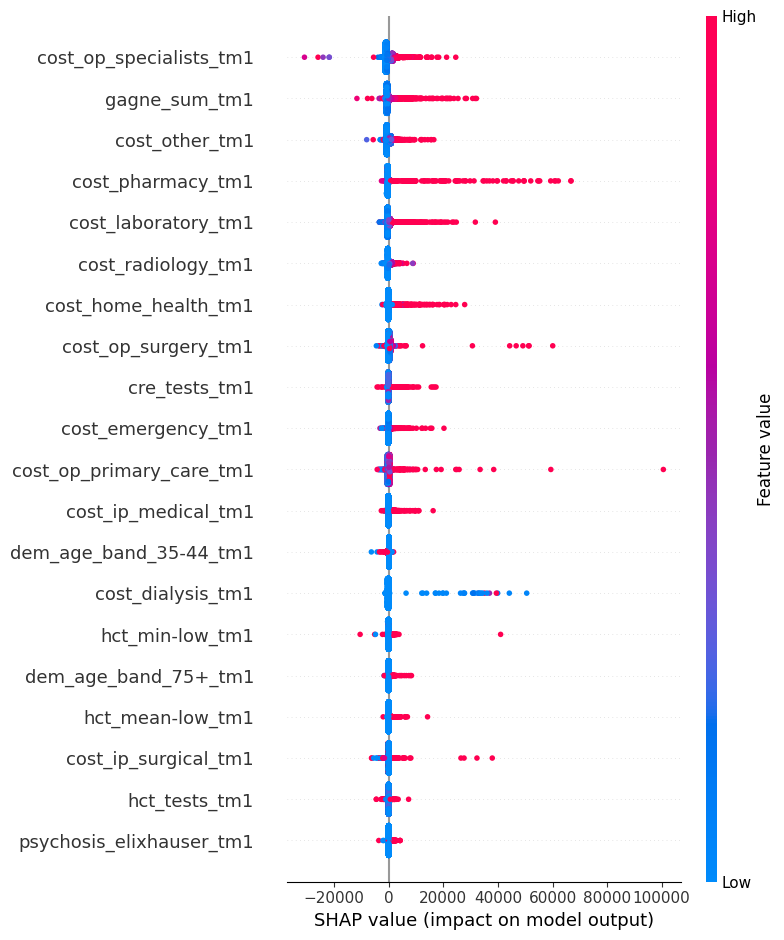


--- SHAP Summary Plot (Classification) ---


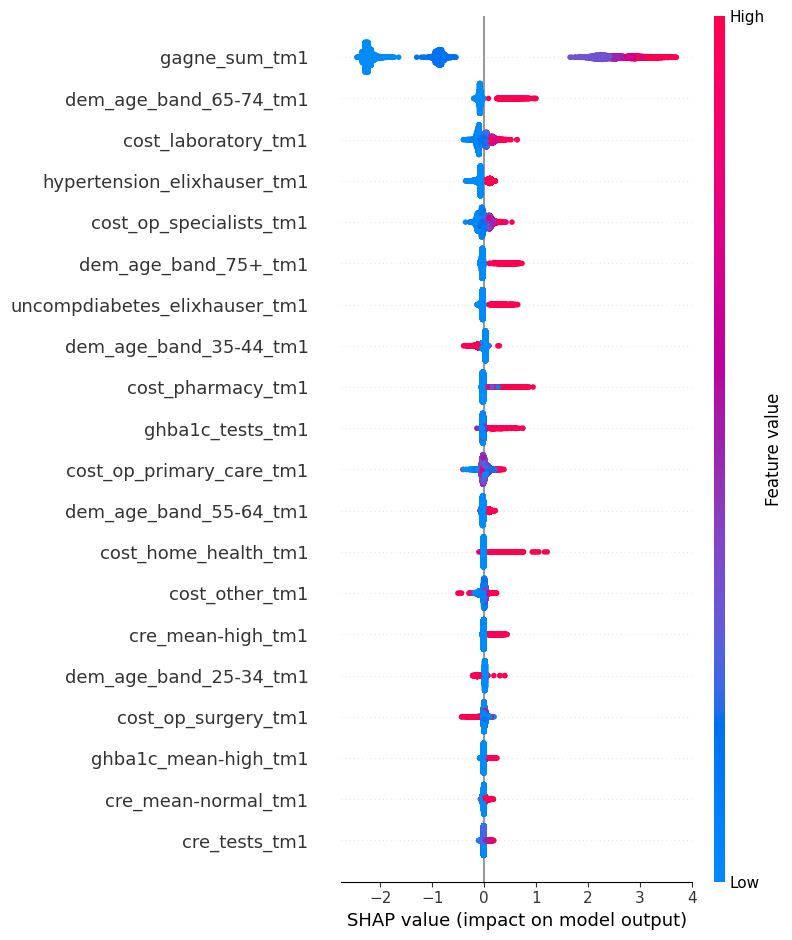

In [11]:
print("\nGenerating SHAP explanations...")

# Regression SHAP
explainer_reg = shap.TreeExplainer(reg_model)
shap_values_reg = explainer_reg.shap_values(X_test_reg)

print("\n--- SHAP Summary Plot (Regression) ---")
shap.summary_plot(shap_values_reg, X_test_reg)

# Classification SHAP
explainer_clf = shap.TreeExplainer(clf_model)
shap_values_clf = explainer_clf.shap_values(X_test_clf)

print("\n--- SHAP Summary Plot (Classification) ---")
shap.summary_plot(shap_values_clf, X_test_clf)

## Local Explainability (LIME)

In this step, we apply local explainability techniques to understand individual predictions.

Following **Session 7: Black Box Explainability — LIME**, we use LIME to approximate the complex model locally with a simpler interpretable model. This allows us to analyse why the model assigned a specific risk score to a particular patient.

Local explanations are especially important in healthcare contexts, where individual decisions may directly affect patient care.

By examining local explanations, we assess whether predictions are driven by clinically meaningful variables or by proxies such as past healthcare expenditure.


--- Example Local Explanation (Regression, first test case) ---


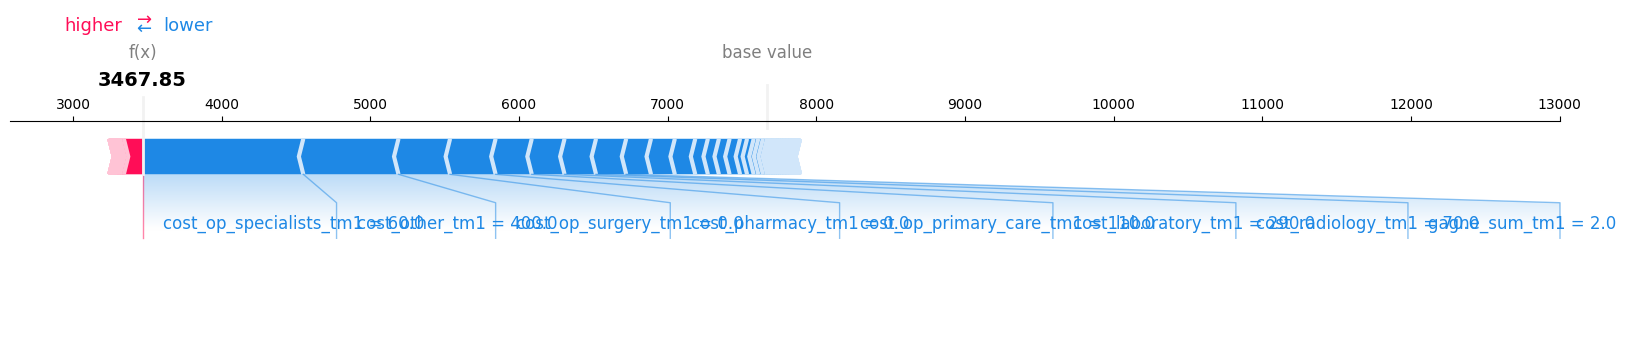

In [12]:
print("\n--- Example Local Explanation (Regression, first test case) ---")
shap.force_plot(
    explainer_reg.expected_value,
    shap_values_reg[0],
    X_test_reg.iloc[0],
    matplotlib=True
)

In [13]:
import xgboost
print(xgboost.__version__)
print(shap.__version__)

1.7.6
0.49.1


## Comparative Analysis and Ethical Reflection

In the final step, we compare the regression and classification models.

We analyse differences in:
- Predictive performance.
- Feature importance.
- Group-level disparities.
- Alignment between objective function and clinical need.

Through this comparison, we evaluate whether predicting healthcare cost leads to different structural behaviour than predicting health burden.

By combining predictive modelling with explainability techniques (Sessions 7 and 8), we critically assess whether the choice of prediction target introduces ethical misalignment.

This step allows us to demonstrate that the design of the prediction task itself can shape model behaviour and potentially embed systemic bias.